In [207]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import os
import uproot
from scipy import interpolate
from scipy.optimize import curve_fit, fsolve

plt.style.use('physics.mplstyle')

In [208]:
def get_limits(fn):
    f = uproot.open(fn)
    limit = f["limit"].array("limit")
    quant = f["limit"].array("quantileExpected")
    if limit.shape[0] == 1:
        return -1
    else:
        return np.stack([quant,limit])

def get_ADD_file(Md=1, d=2, path="./results/2016_ADD/"):
    fname = os.path.join(
        "fitroom/higgsCombineADD_MD_{}_d_{}.AsymptoticLimits.mH125.root".format(Md, d)
    )
    if os.path.isfile(fname):
        return fname
    else:
        pass
        
import yaml
xsections = {}
with open("config/xsections_2016.yaml", 'r') as stream:
    xsections = yaml.safe_load(stream)

thxsec = pd.read_csv("config/xsec-ADDtheory.csv")
def get_xsec(md=1, d=2):
    try:
        d = xsections[
            "ADDMonoZ_ZToLL_MD-{md}_d-{dim}_TuneCUETP8M1_13TeV-pythia8".format(
                md=md,dim=d
            )]
    except:
        d = xsections[
            "ADDMonoZ_ZtoLL_MD-{md}_d-{dim}_TuneCUETP8M1_13TeV-pythia8".format(
                md=md,dim=d
            )]
    return d.get("xsec") * d.get("br",1.0) * d.get("kr",1.0)

In [209]:
get_xsec(md=1, d=2)

0.05656

In [210]:
d = 4
for md in range(1,4):
    limit = get_limits(get_ADD_file(Md=md, d=d))
    print(md, d, " : ", 
          np.round(limit[1,2]*0.06738*3/2,5), "+/- [",
          np.round(limit[1,1]*0.06738*3/2,5), ",",
          np.round(limit[1,3]*0.06738*3/2,5), "]")

1 4  :  0.00222 +/- [ 0.00151 , 0.00325 ]
2 4  :  0.02477 +/- [ 0.01715 , 0.03603 ]
3 4  :  0.15082 +/- [ 0.10442 , 0.21935 ]


In [232]:
def plot_dim_interpolate(dim=2, unblind=True, quadratic=False):
    limits = []
    limitx = []
    for md in range(1,4):
        try:
            limit = get_limits(get_ADD_file(Md=md, d=dim))
            xsec = get_xsec(md=md, d=dim) * 1000 #*3/2/0.101
            if not isinstance(limit, int) and limit.shape == (2,6):
                limits.append(limit * xsec)
                limitx.append(md)
        except:
            print(" failed : ", md, " : ", dim)
            pass
    limits = np.array(limits)
    limitx = np.array(limitx)
    
    _exp = np.array([l[1][2] for l in limits]) 
    _s1p = np.array([l[1][1] for l in limits]) 
    _s1m = np.array([l[1][3] for l in limits]) 
    _s2p = np.array([l[1][0] for l in limits]) 
    _s2m = np.array([l[1][4] for l in limits])
    
    if quadratic:
        exp_limit = interpolate.interp1d(limitx, _exp, bounds_error=False, fill_value="extrapolate", kind="quadratic")
        s1p_limit = interpolate.interp1d(limitx, _s1p, bounds_error=False, fill_value="extrapolate", kind="quadratic")
        s1m_limit = interpolate.interp1d(limitx, _s1m, bounds_error=False, fill_value="extrapolate", kind="quadratic")
        s2p_limit = interpolate.interp1d(limitx, _s2p, bounds_error=False, fill_value="extrapolate", kind="quadratic")
        s2m_limit = interpolate.interp1d(limitx, _s2m, bounds_error=False, fill_value="extrapolate", kind="quadratic")
    else:
        exp_limit = interpolate.interp1d(limitx, _exp, bounds_error=False, fill_value="extrapolate", kind="linear")
        s1p_limit = interpolate.interp1d(limitx, _s1p, bounds_error=False, fill_value="extrapolate", kind="linear")
        s1m_limit = interpolate.interp1d(limitx, _s1m, bounds_error=False, fill_value="extrapolate", kind="linear")
        s2p_limit = interpolate.interp1d(limitx, _s2p, bounds_error=False, fill_value="extrapolate", kind="linear")
        s2m_limit = interpolate.interp1d(limitx, _s2m, bounds_error=False, fill_value="extrapolate", kind="linear")        
    plt.figure(figsize=(6,6))
    ax = plt.gca()
    
    plt.plot(limitx, _exp,'.', ms=12, color='black')
    xvar = np.linspace(0,4,101)
    plt.plot(xvar, exp_limit(xvar), ls="--", ms=12, color='black', label="Median expected")
    
    plt.fill_between(xvar, s2m_limit(xvar), s2p_limit(xvar), color="#FFCC01", lw=0, label="Expected $\pm 2\sigma$")
    plt.fill_between(xvar, s1m_limit(xvar), s1p_limit(xvar), color="#00CC00", lw=0, label="Expected $\pm 1\sigma$")

    plt.plot(thxsec[thxsec.d==dim].Md, 
             thxsec[thxsec.d==dim].xsec * 1000 * 0.101* 2/3, 
             "--", ms=12, color='blue', label="$\sigma_{theory}$ (pb), n = %i" % (dim))
    plt.ylim([0.0, 10 ])
    plt.xlim([0.9, 3.3 ])
    
    plt.ylabel(r"$\sigma(pp\to GZ)$ (fb)")
    plt.xlabel(r"$M_d$ (TeV)")
    plt.legend(loc="upper left", fontsize=14)
    cms = plt.text(
        0., 1., u"CMS $\it{preliminary}$",
        fontsize=16, fontweight='bold',
        horizontalalignment='left', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    lumi = plt.text(
        1., 1., r"%.1f fb$^{-1}$ (13 TeV)" % 35.9,
        fontsize=14, horizontalalignment='right', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    plt.grid(b=True, which='major', color='grey', linestyle='--', alpha=0.3)
    plt.savefig("plots/ADD_limits_d_{}.pdf".format(dim))
    plt.savefig("plots/ADD_limits_d_{}.png".format(dim))
    plt.show()

In [233]:
get_limits(get_ADD_file(Md=1, d=2))

array([[ 0.025     ,  0.16      ,  0.5       ,  0.83999997,  0.97500002,
        -1.        ],
       [ 0.02380371,  0.03281593,  0.046875  ,  0.06817541,  0.09519068,
         0.04690752]])

In [234]:
get_xsec(md=1, d=2)

0.05656

dim :  2


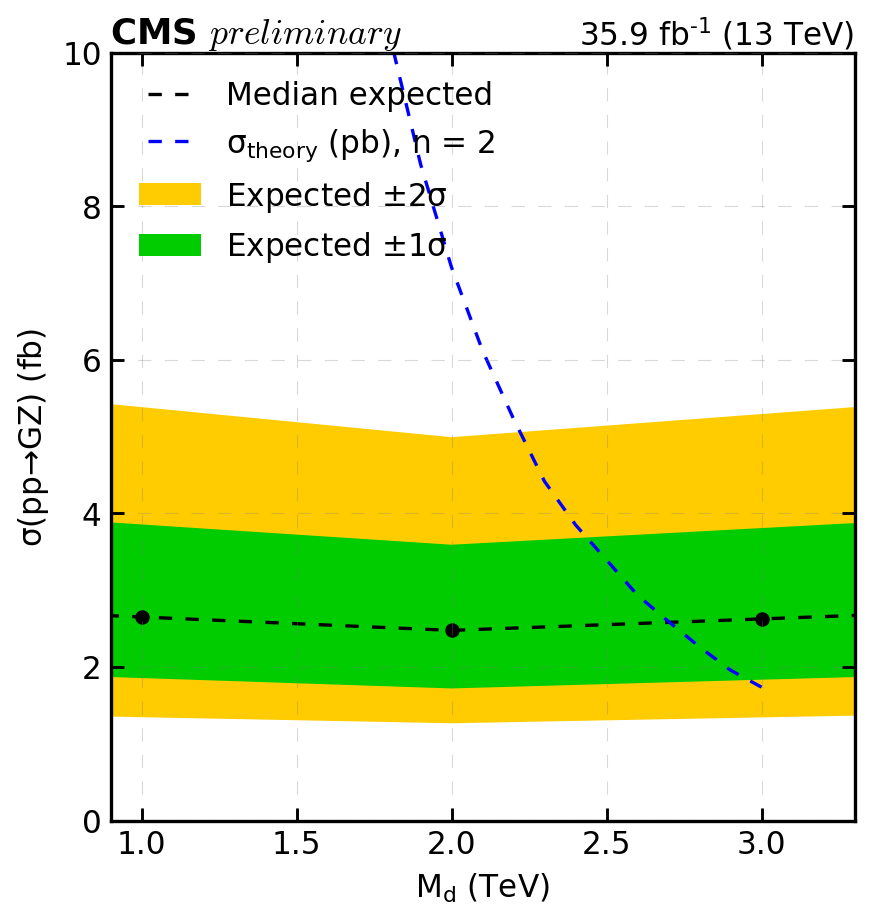

dim :  3


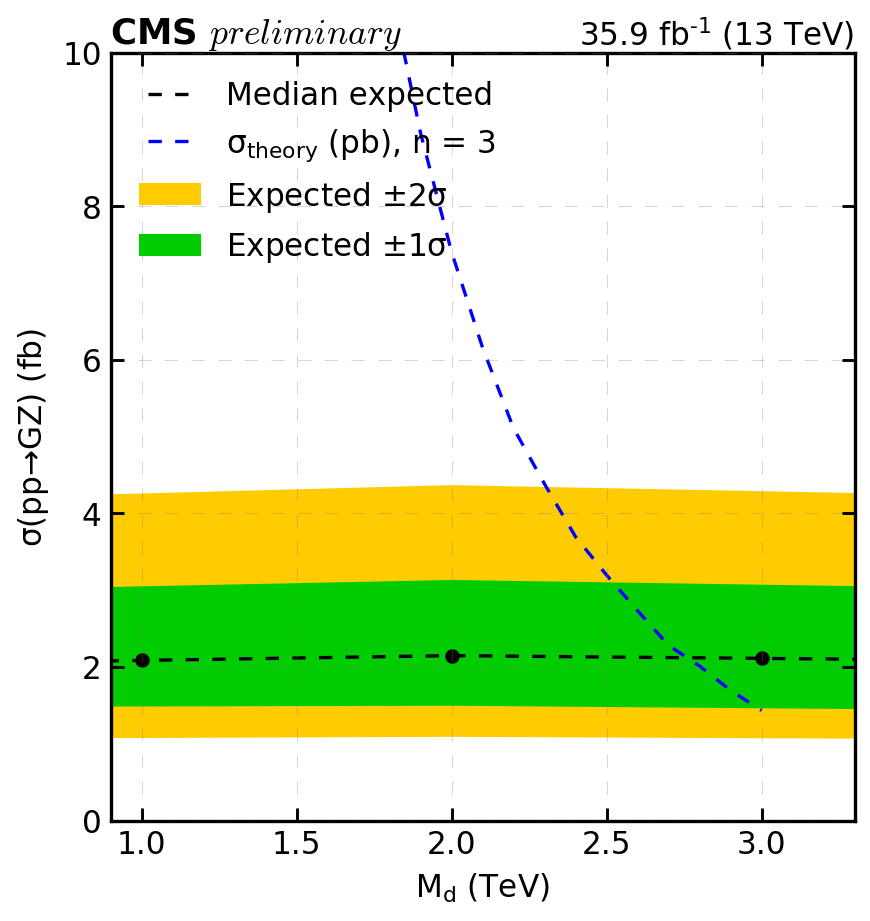

dim :  4


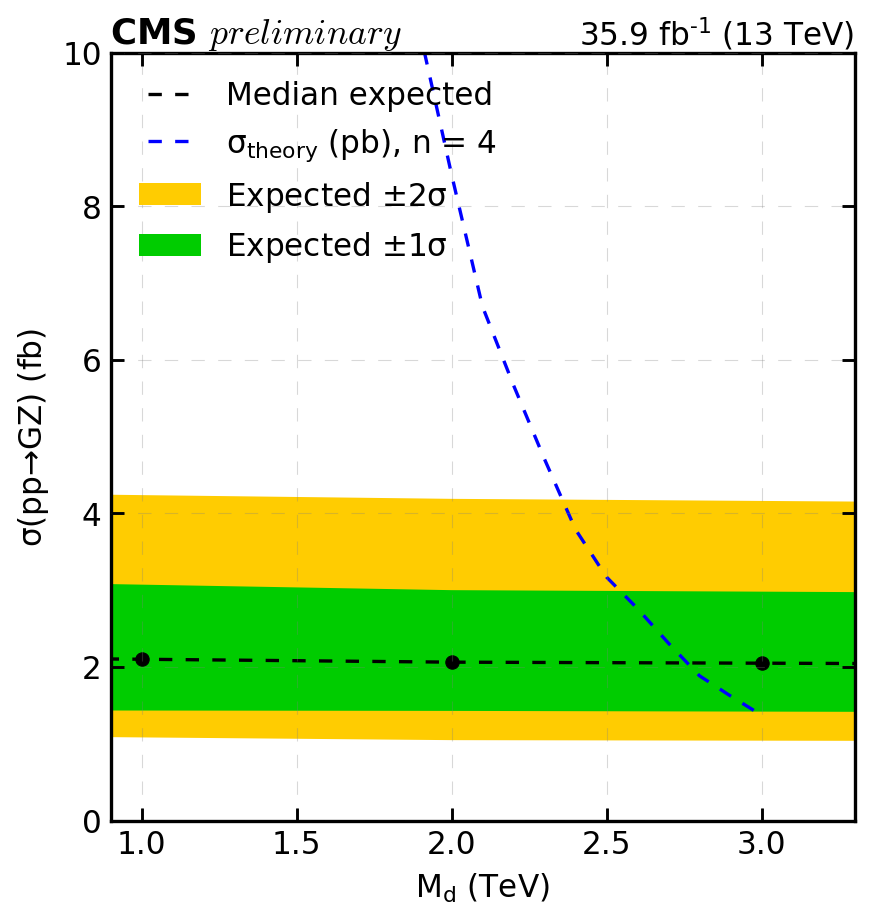

dim :  5


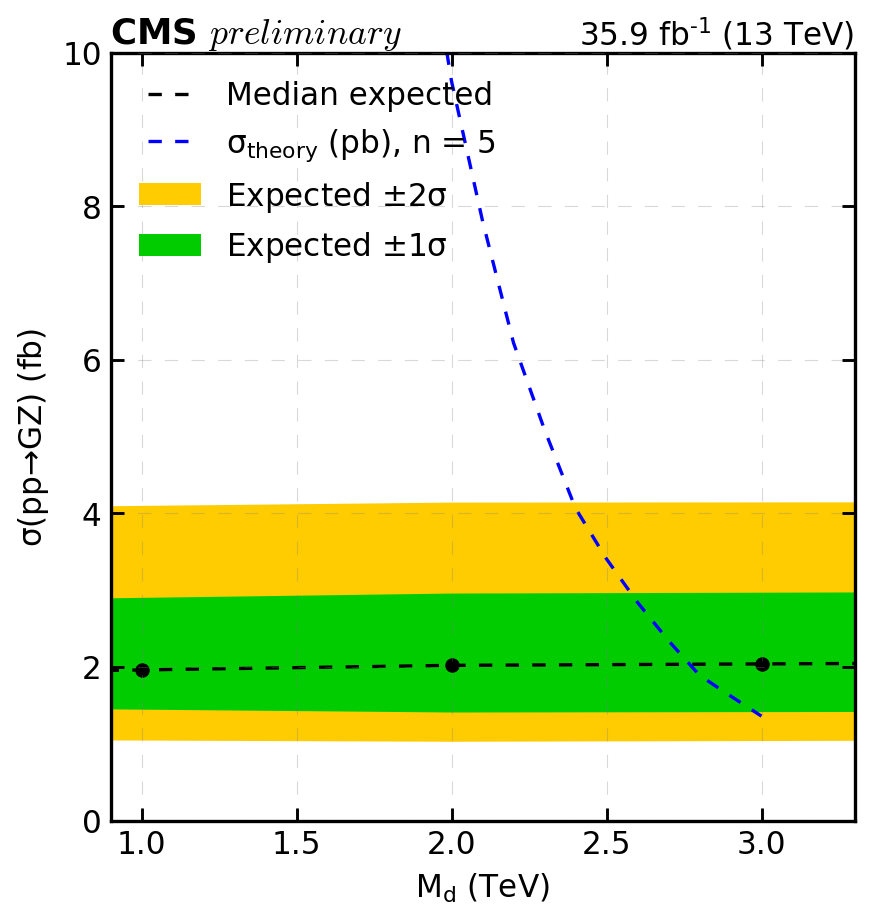

dim :  6


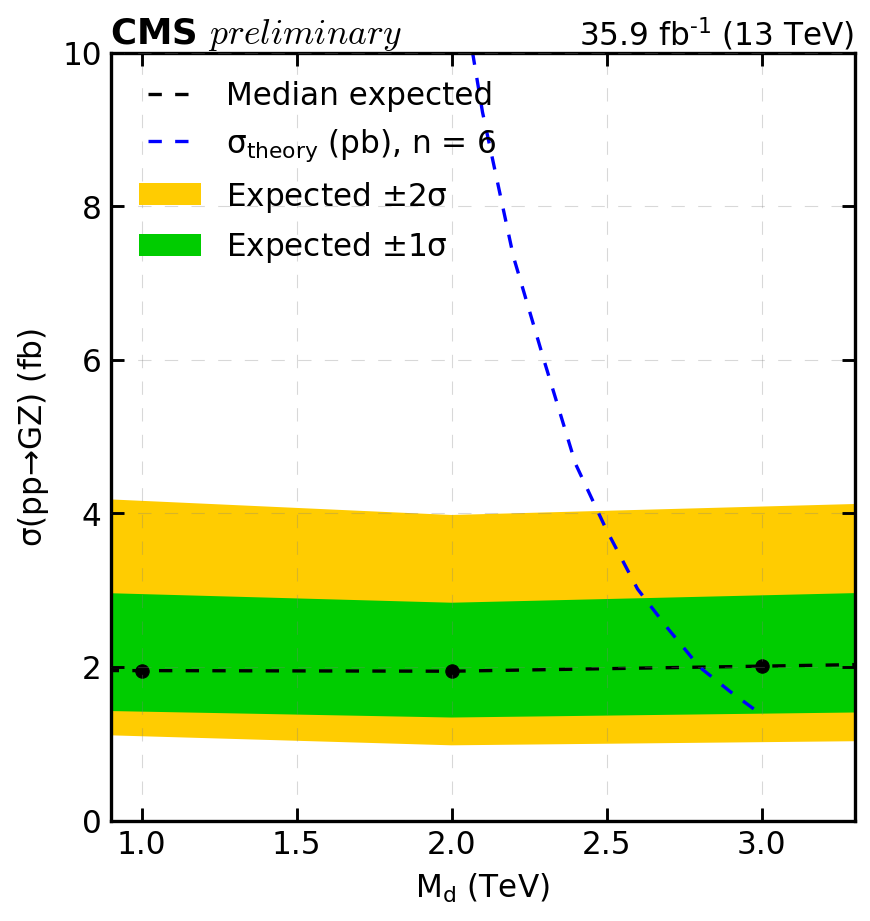

dim :  7


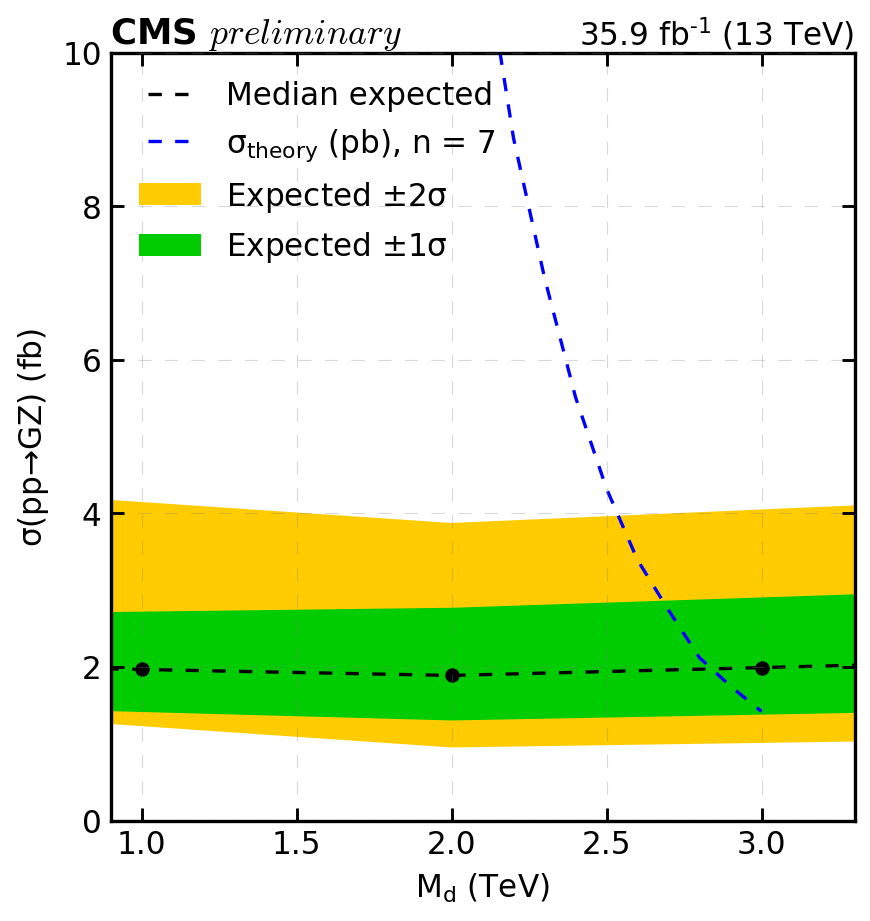

In [236]:
for d in range(2,8):
    print("dim : ", d)
    plot_dim_interpolate(d, False)